In [23]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from os import walk
import matplotlib.pyplot as plt
%matplotlib inline 

In [24]:
#update the mac list - this will only run under Macbook
#os.system("scp -i ~/.ssh/router mac-names.txt root@192.168.11.1:/tmp/var/bwmon/www/mac-names.js")
# move the dailyfiles - look for a 0 return code
os.system("scp -i ~/.ssh/router root@192.168.11.1:/var/bwmon/data/*.dat /Users/samuelcroker/Documents/routerdata")

0

In [25]:
maccsv = '/Users/samuelcroker/Documents/repositories/Router-tools/mac-names.csv'
macdf = pd.read_csv(maccsv, names = ['mac','devicename'],quotechar="'")
dailypath = '/Users/samuelcroker/Documents/routerdata/'
dailyfiles = []
for (dirpath, dirnames, filenames) in walk(dailypath):
    dailyfiles.extend(filenames)
    break

In [26]:
cutoff = 1.5
idx = 0
for f in dailyfiles:
    #print(idx)
    if f[-3:] == 'dat':
        df = pd.read_csv(dailypath+f, names = ['Device','PostIN KB','PostOut KB','PreIn KB','PreOut KB','LastSeen'])
        df['dtstamp'] = np.repeat(dt.date(int(f[6:10]),int(f[10:12]),int(f[12:14])),len(df))
        df['idx'] = idx
        if idx == 0:
            finaldf = df.copy()                 
        else:
            finaldf = pd.concat([finaldf,df])
        idx += 1
#calculate the totalGB column. This is approximate but very close...
finaldf['totalGB'] = (finaldf['PostIN KB'] + finaldf['PostOut KB'])/1e6
#join with devicenames
finaldf = finaldf.merge(macdf, left_on='Device', right_on='mac', how='left')
#Make sure unknown devices are not ignored in the groupby by replacing the null devicename with
# the mac address
finaldf.devicename.fillna(finaldf.Device, inplace=True)

In [27]:
# create summaries
Alltotal = finaldf.groupby(['Device','devicename'])['totalGB'].sum()

devicetotal = finaldf.groupby(['devicename'])['totalGB'].sum()
dailytotal = finaldf.groupby(['dtstamp'])['totalGB'].sum()
smalldaily = finaldf[finaldf.totalGB < cutoff].groupby(['dtstamp','devicename'])['totalGB'].sum()

# make the devicenames "other" when the gb is < 1
finaldf.loc[finaldf['totalGB'] < cutoff, 'devicename'] = 'Other'
devicedaily = finaldf.groupby(['dtstamp','devicename'])['totalGB'].sum()

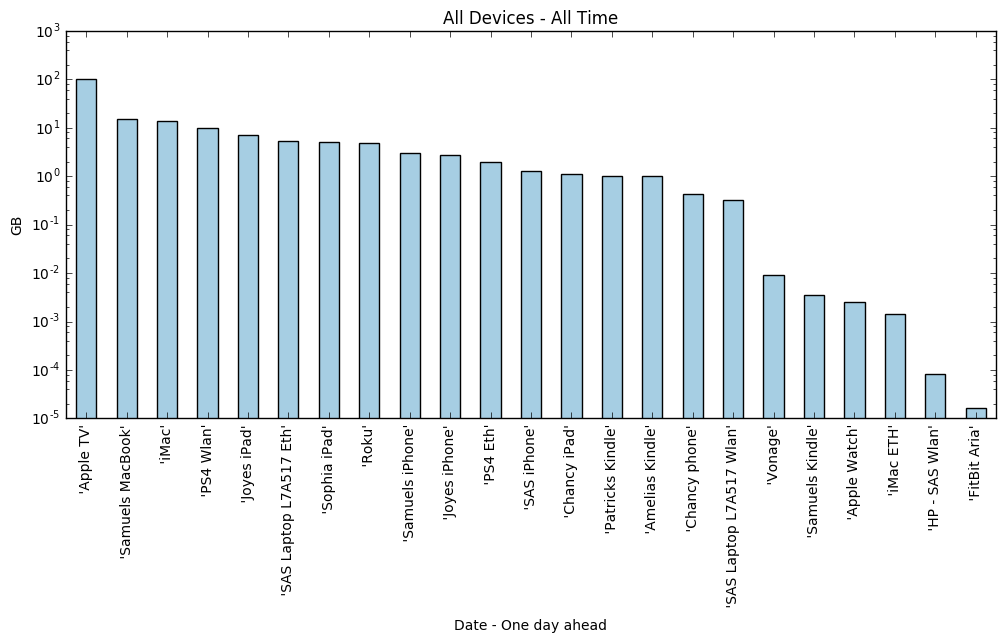

In [28]:
#df0 = devicetotal.unstack('devicename').fillna(0)
pp0 = devicetotal.sort_values(ascending=False).plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5),logy=True)
pp0.set_xlabel('Date - One day ahead')
pp0.set_ylabel('GB')
pp0.set_title("All Devices - All Time")

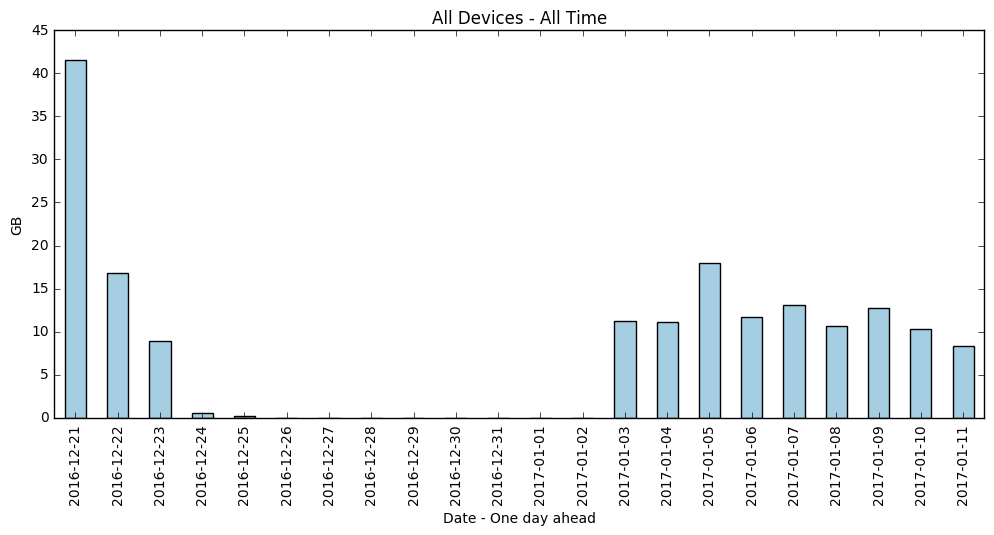

In [29]:
#df0 = devicetotal.unstack('devicename').fillna(0)
pp0 = dailytotal.plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5))
pp0.set_xlabel('Date - One day ahead')
pp0.set_ylabel('GB')
pp0.set_title("All Devices - All Time")

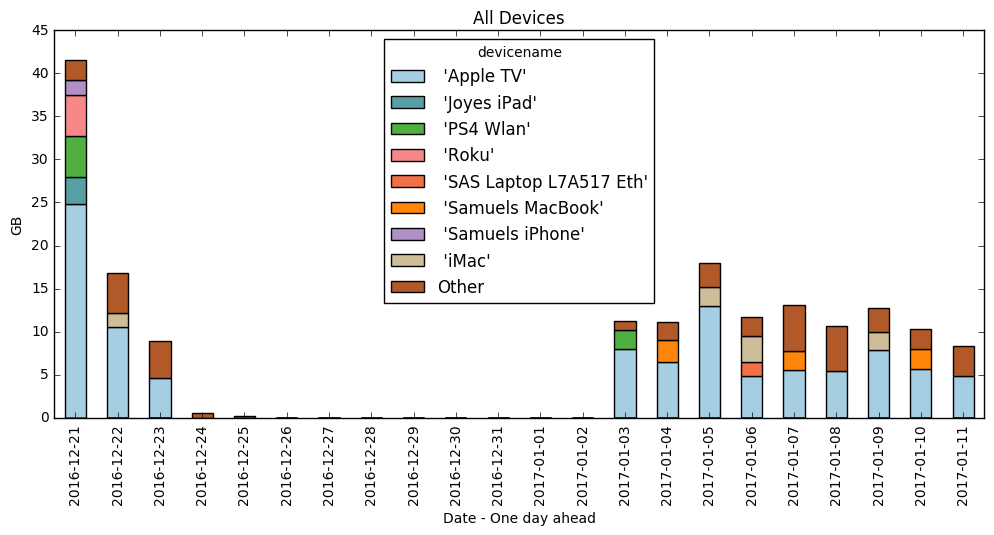

In [30]:
df2 = devicedaily.unstack('devicename').fillna(0)
pp2 = df2.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 5))
pp2.set_xlabel('Date - One day ahead')
pp2.set_ylabel('GB')
pp2.set_title("All Devices")

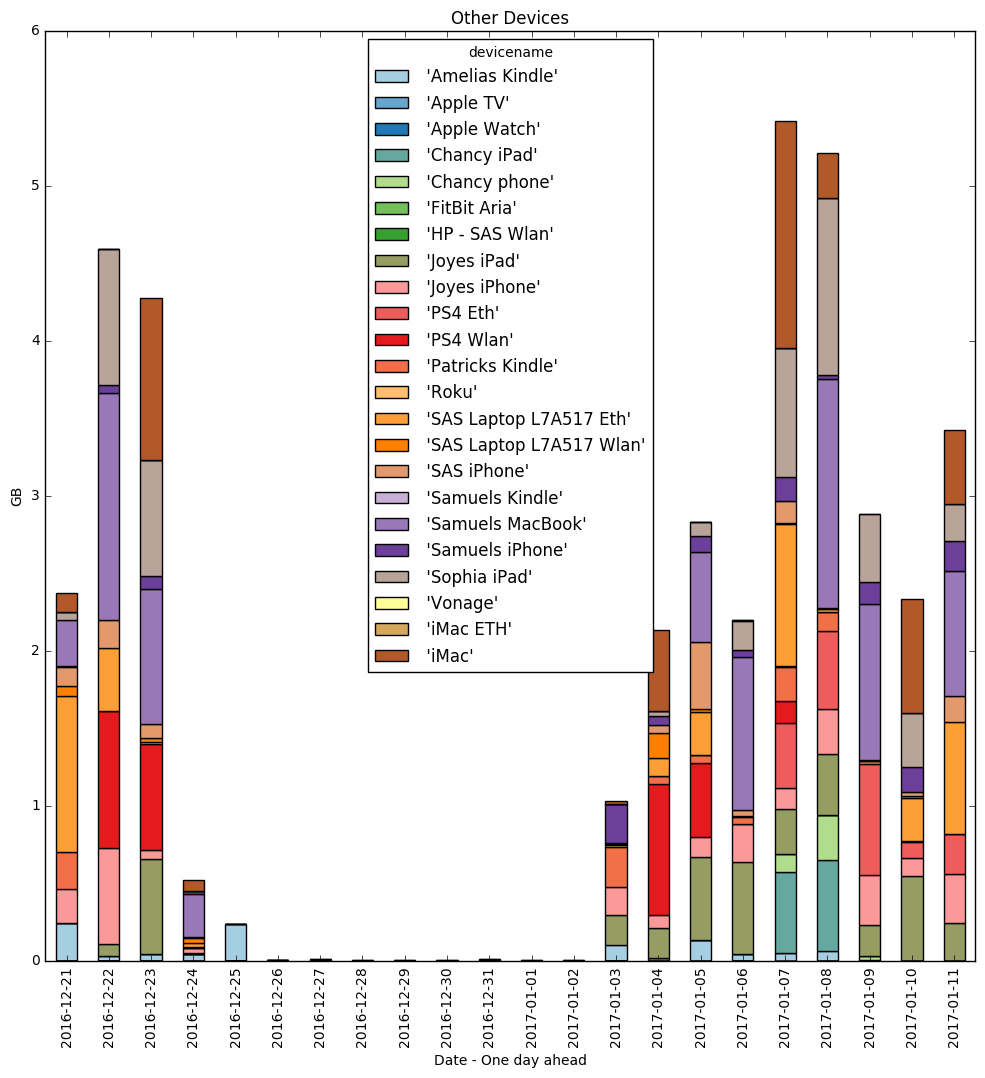

In [31]:
df3 = smalldaily.unstack('devicename').fillna(0)
pp3 = df3.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 12))
pp3.set_xlabel('Date - One day ahead')
pp3.set_ylabel('GB')
pp3.set_title("Other Devices")